# PCML Project-1 ~ Team #60

## Initial Python Imports

In [17]:
# Useful starting lines
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from test import *

from costs import compute_loss

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [9]:
from proj1_helpers import *
from helpers import *

DATA_TRAIN_PATH = "../Data/train.csv" # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

#print the shape of the offset x matrix.
print('y shape: ',y.shape)
print('original tX shape: ',tX.shape)
print('ids shape: ',ids.shape)

y shape:  (200,)
original tX shape:  (200, 30)
ids shape:  (200,)


## Data preprocessing

### Count Outliers - Extreme values

In [10]:
outliers = count_outliers(tX,-999)
for feature in range(tX.shape[1]):
    print('feature: ',feature,' -> ',outliers[feature])

feature:  0  ->  35.0
feature:  1  ->  0.0
feature:  2  ->  0.0
feature:  3  ->  0.0
feature:  4  ->  144.0
feature:  5  ->  144.0
feature:  6  ->  144.0
feature:  7  ->  0.0
feature:  8  ->  0.0
feature:  9  ->  0.0
feature:  10  ->  0.0
feature:  11  ->  0.0
feature:  12  ->  144.0
feature:  13  ->  0.0
feature:  14  ->  0.0
feature:  15  ->  0.0
feature:  16  ->  0.0
feature:  17  ->  0.0
feature:  18  ->  0.0
feature:  19  ->  0.0
feature:  20  ->  0.0
feature:  21  ->  0.0
feature:  22  ->  0.0
feature:  23  ->  87.0
feature:  24  ->  87.0
feature:  25  ->  87.0
feature:  26  ->  144.0
feature:  27  ->  144.0
feature:  28  ->  144.0
feature:  29  ->  0.0


### Standardization

In [11]:
#standardization
# tX, mean_x, std_x = standardize(tX, mean_x=None, std_x=None)
tX_train, _, _ = standardize_outliers(tX)
print('standardized tX shape: ',tX.shape)
# print('tX mean shape: ',mean_x.shape)
# print('tX std shape: ',std_x.shape)

200 30
(200, 31)
standardized tX shape:  (200, 30)


### Analysis of output y

In [ ]:
# Histogram of output y
plt.hist(y, bins=10, align='mid')
plt.title("Histogram of output y")
plt.show()

### Analysis of y as a function of all its features (one by one)

In [ ]:
# Analyse y as a function of all the other features (one by one)
plot_features_by_y(y,tX)

## Linear regression using gradient descent

In [7]:
from gradient_descent import least_squares_GD

# Define the parameters of the algorithm.
max_iters = 1000
gamma = 0.01
# Initialization
w_initial = np.zeros(tX.shape[1])
# Start gradient descent.
gradient_losses, gradient_ws = least_squares_GD(y, tX, w_initial, gamma, max_iters)


y shape:  (250000,)
tx shape:  (250000, 30)
Gradient Descent(0/999): loss=0.5
Gradient Descent(1/999): loss=0.4960259021131301
Gradient Descent(2/999): loss=0.4923109658542728
Gradient Descent(3/999): loss=0.4888317608849261
Gradient Descent(4/999): loss=0.48556733695387544
Gradient Descent(5/999): loss=0.4824989446355241
Gradient Descent(6/999): loss=0.4796097882241068
Gradient Descent(7/999): loss=0.4768848070514233
Gradient Descent(8/999): loss=0.4743104819302093
Gradient Descent(9/999): loss=0.4718746638091148
Gradient Descent(10/999): loss=0.46956642206437404
Gradient Descent(11/999): loss=0.4673759101528658
Gradient Descent(12/999): loss=0.46529424661594687
Gradient Descent(13/999): loss=0.4633134096573078
Gradient Descent(14/999): loss=0.4614261437247118
Gradient Descent(15/999): loss=0.4596258767080175
Gradient Descent(16/999): loss=0.45790664652717655
Gradient Descent(17/999): loss=0.4562630360263872
Gradient Descent(18/999): loss=0.45469011521649483
Gradient Descent(19/999): 

## Linear regression using stochastic gradient descent

In [ ]:
from stochastic_gradient_descent import least_squares_SGD

# Define the parameters of the algorithm.
max_iters = 1000
gamma = 0.01
batch_size = 1
# Initialization
w_initial = np.zeros(tX.shape[1])
# Start SGD.
stoch_gradient_losses, stoch_gradient_ws = least_squares_SGD(y, tX, w_initial, batch_size, gamma, max_iters)

min_stoch_i, min_stoch_loss = get_min_param_index(stoch_gradient_losses)
print('min index: ',min_stoch_i)
print('min loss: ',min_stoch_loss)

## Least squares regression using normal equations

In [ ]:
from least_squares import least_squares

ls_wopt, ls_loss = least_squares(y,tX)
print('loss=',ls_loss)
print('parameters w: ',ls_wopt)

## Ridge regression using normal equations

[[ 5.     0.8  ]
 [ 0.     0.775]
 [ 0.     0.75 ]
 [ 0.     0.75 ]
 [ 1.     0.75 ]
 [ 5.     0.8  ]
 [ 0.     0.825]
 [ 5.     0.825]
 [ 2.     0.775]
 [ 4.     0.775]
 [ 0.     0.775]
 [ 2.     0.8  ]
 [ 0.     0.8  ]
 [ 4.     0.775]
 [ 0.     0.775]
 [ 2.     0.8  ]
 [ 0.     0.75 ]
 [ 2.     0.775]
 [ 0.     0.8  ]
 [ 3.     0.775]
 [ 0.     0.75 ]
 [ 0.     0.775]
 [ 2.     0.775]
 [ 0.     0.775]
 [ 0.     0.775]
 [ 0.     0.775]
 [ 0.     0.775]
 [ 2.     0.8  ]
 [ 0.     0.75 ]]
(200, 40)
[[ 5.     0.8  ]
 [ 0.     0.775]
 [ 0.     0.75 ]
 [ 0.     0.75 ]
 [ 1.     0.75 ]
 [ 5.     0.8  ]
 [ 0.     0.825]
 [ 5.     0.825]
 [ 2.     0.775]
 [ 4.     0.775]
 [ 0.     0.775]
 [ 2.     0.8  ]
 [ 0.     0.8  ]
 [ 4.     0.775]
 [ 0.     0.775]
 [ 2.     0.8  ]
 [ 0.     0.75 ]
 [ 2.     0.775]
 [ 0.     0.8  ]
 [ 3.     0.775]
 [ 0.     0.75 ]
 [ 0.     0.775]
 [ 2.     0.775]
 [ 0.     0.775]
 [ 0.     0.775]
 [ 0.     0.775]
 [ 0.     0.775]
 [ 2.     0.8  ]
 [ 0.     0.75 ]]
(2

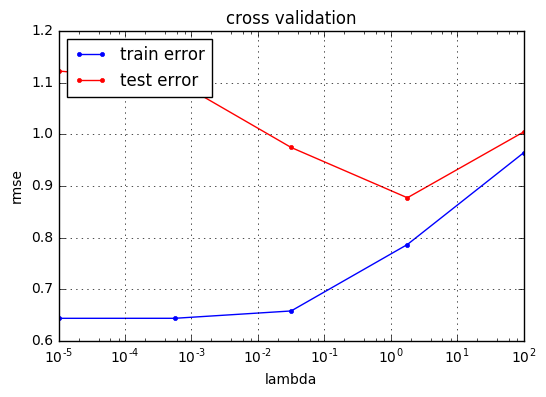

In [15]:
from ridge_regression import cross_validation_ridge_regression
from build_polynomial import build_poly
from poly import *
from build_polynomial import *

min_rr_rmse,best_rr_lambda = (cross_validation_ridge_regression(y,tX,k_fold=10))

In [19]:
from ridge_regression import ridge_regression

best_deg = find_best_poly(y, tX_train[:,1:],test_RR)
opt_tr = build_optimal(tX_train[:,1:], best_deg)
w_ridge, ridge_loss = ridge_regression(y, opt_tr,best_rr_lambda)

print('loss: ',ridge_loss)
print('parameters w: ',w_ridge)

[[ 2.     0.825]
 [ 5.     0.8  ]
 [ 2.     0.775]
 [ 5.     0.775]
 [ 0.     0.75 ]
 [ 2.     0.775]
 [ 4.     0.8  ]
 [ 0.     0.825]
 [ 5.     0.825]
 [ 1.     0.75 ]
 [ 3.     0.775]
 [ 0.     0.75 ]
 [ 3.     0.8  ]
 [ 4.     0.8  ]
 [ 4.     0.775]
 [ 0.     0.75 ]
 [ 2.     0.775]
 [ 0.     0.775]
 [ 5.     0.775]
 [ 0.     0.775]
 [ 3.     0.775]
 [ 0.     0.775]
 [ 0.     0.75 ]
 [ 0.     0.75 ]
 [ 0.     0.775]
 [ 0.     0.775]
 [ 0.     0.75 ]
 [ 0.     0.775]
 [ 0.     0.775]
 [ 1.     0.75 ]]
(200, 52)
loss:  0.284033488627
parameters w:  [-0.0263187   0.01158362 -0.03933718 -0.04891752 -0.01838251 -0.0511348
 -0.01086517  0.00664632  0.00693832 -0.03589002  0.0146597   0.0027643
  0.01849414  0.01061297 -0.0043979   0.00883833  0.0152619   0.00113195
  0.0174042  -0.01392594  0.0146732  -0.00250006 -0.00819308 -0.01044038
 -0.01719831  0.00492555  0.03537614 -0.02481036 -0.00364749 -0.01590135
  0.00790204  0.00335939  0.01418658  0.031905   -0.00810612  0.02822154
 -0.00

## Logistic regression using gradient descent or SGD

In [ ]:
from logistic_regression import logistic_regression_gradient_descent
from plots import visualization

lr_loss, lr_w = logistic_regression_gradient_descent(y, tX)

## Regularized logistic regression using gradient descent or SGD

## Kaggle score Aproximation

In [20]:
test_GD(y, tX, ratio=0.2)

GD test
parameters w:  [-0.03574765 -0.29307716 -0.25622237  0.02914541  0.01437547  0.15190617
  0.22636287  0.28250279 -0.09065928  0.14286233 -0.14485509  0.04698598
  0.18770091  0.1328155  -0.10799591  0.04080291  0.04158353 -0.05181993
 -0.10623274  0.09005564 -0.14231326 -0.00480513 -0.06340605  0.09870042
  0.09999228 -0.16019252  0.08644647 -0.17649949 -0.11447075  0.12312552]


0.7

In [21]:
test_SGD(y, tX, ratio=0.2,max_iters=10000)

SGD test
parameters w:  [-0.05156778 -0.18065851 -0.09073065 -0.00239607  0.02824679  0.05645477
  0.01136668  0.14440678 -0.10286569  0.02112294 -0.1271831   0.07590447
  0.08419775  0.05606966 -0.04511965  0.08109771 -0.13074    -0.03614835
 -0.08166958 -0.03843294 -0.11223096 -0.02342437 -0.01267796  0.05771319
  0.08870854 -0.07798771  0.04068466 -0.08403514 -0.05952428  0.04321297]


0.675

In [22]:
test_LS(y, tX, ratio=0.2)

0.675

In [24]:
test_RR(y, opt_tr, ratio=0.2,lambda_=best_rr_lambda)

0.7

In [ ]:
test_LR(y, tX, ratio=0.2,threshold=0.5)

In [ ]:
# test_RLR(y, tX, ratio=0.2)

## Generate predictions and save ouput in csv format for submission:

In [ ]:
# Gradient Descent
weights = gradient_ws[-1]

In [ ]:
# Stochastic Gradient Descent
weights = stoch_gradient_ws[min_stoch_i]

In [ ]:
# Least Squares
weights = ls_wopt

In [ ]:
# Ridge Regression
weights = w_ridge

In [ ]:
# Logistic Regression
weights = lr_w

In [ ]:
# weights =

In [ ]:
DATA_TEST_PATH = "../Data/test.csv" # TODO: download test data and supply path here 
y_test, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_test, _, _ = standardize_outliers(tX_test)

In [ ]:
OUTPUT_PATH = '../Data/results.csv' # TODO: fill in desired name of output file for submission
# y_pred = predict_logistic_labels(weights, tX_test,threshold=0.5)
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [ ]:
from poly import build_optimal

OUTPUT_PATH = '../Data/results.csv' # TODO: fill in desired name of output file for submission

tx = tX_test[:,1:]
opt_tr = build_optimal(tx, best_deg)

y_pred = predict_labels(w, opt_tr)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)